In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import numpy as np
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

In [2]:
import dtale

In [3]:
df = pd.read_csv(r"C:\Users\admin\Downloads\bigsales.csv")

As we can see, we need to predict the sales of each product at a particular outlet. Based on the features, I'm writting down the questions that arises within my mind.
these are my hypothesis questions...
1. does light weight items get sold the most ?
2. do less fat content products get sold the most ?
3. do more visibility products get sold the most ?
4. do cheap products get sold the most ?

5. do older established marts have more selling rate of a product than newly established ?
6. do larger outlet size means more product sell ?
7. do tier 1 cities have more selling power than tier 3 ?
8. does types of outlet effect item sales ?

In [4]:
df.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

In [5]:
df.Item_Fat_Content.value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [6]:
item_id = df['Item_Identifier']
outlet_id = df['Outlet_Identifier']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


observation:
1. only features named item weight and outlet size has mising values

In [8]:
df.describe()

Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  7060.000000      8523.000000  8523.000000                8523.000000   
mean     12.857645         0.066132   140.992782                1997.831867   
std       4.643456         0.051598    62.275067                   8.371760   
min       4.555000         0.000000    31.290000                1985.000000   
25%       8.773750         0.026989    93.826500                1987.000000   
50%      12.600000         0.053931   143.012800                1999.000000   
75%      16.850000         0.094585   185.643700                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800

In [9]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

In [10]:
missing_zero_values_table(df)

Your selected dataframe has 12 columns and 8523 Rows.
There are 2 columns that have missing values.


Zero Values  Missing Values  % of Total Values  \
Outlet_Size            0            2410               28.3   
Item_Weight            0            1463               17.2   

             Total Zero Missing Values  % Total Zero Missing Values Data Type  
Outlet_Size                       2410                         28.3    object  
Item_Weight                       1463                         17.2   float64

In [11]:
#Seperating numerical and categorical data
cols = df.columns
num_cols = df._get_numeric_data().columns
num_df = df[num_cols]
categorical_list = list(set(cols) - set(num_df))
categ_df = df[categorical_list]

<h2> EDA

<h4> 1. Analysis of categorical features

<h5>a. Univariate analysis of categorical features -

In [12]:
categ_df.columns

Index(['Item_Type', 'Item_Fat_Content', 'Outlet_Type', 'Outlet_Location_Type',
       'Outlet_Identifier', 'Outlet_Size', 'Item_Identifier'],
      dtype='object')

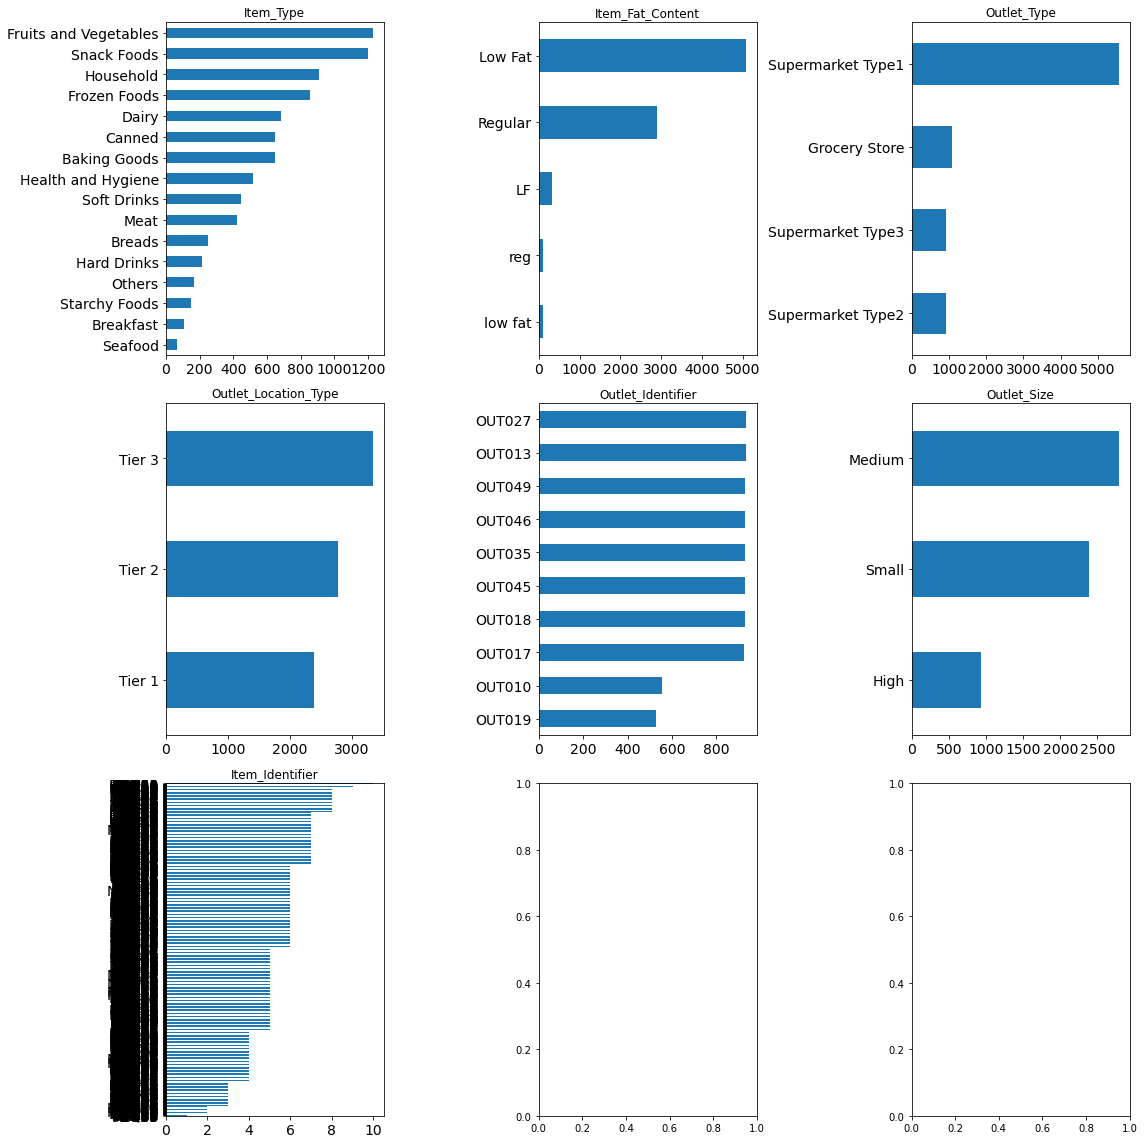

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(categ_df):
    _ = categ_df[c].value_counts()[::-1].plot(kind = 'barh', ax=axes[i], title=c, fontsize=14)
    
_ = plt.tight_layout()

observations:-
1. fruits and vegetables are the items which are sold the most as expected due to our vegetarian food culture in india.
2. medium sized outlets are the most in number.
3. tier 3 cities have most numbers of outlets.
4. low fat foods are consumed the most.

##### **b. Bivariate Analysis Relationships with Target**

Do larger outlet size means more product sell ?

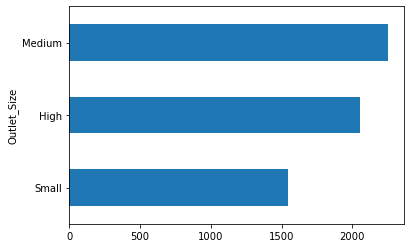

In [14]:
_ = df.groupby('Outlet_Size')['Item_Outlet_Sales'].median().sort_values().plot(kind = 'barh')

conclusion:- No, medium sized outlets have more no of item sales.

Does higher market type means more sales?

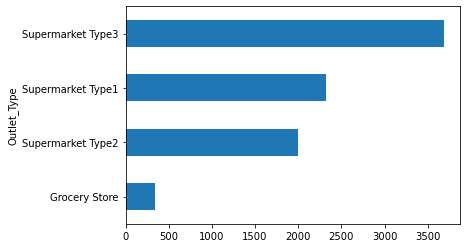

In [15]:
_ = df.groupby('Outlet_Type')['Item_Outlet_Sales'].mean().sort_values().plot(kind = 'barh')

In [16]:
#checking with anova and p value
# null hypothesis - higher market type means more sales
# alternative hypothesis - market type dosent effect sales in anyway.
def anova_outlettype(df):
    df_anova = df[['Item_Outlet_Sales','Outlet_Type']]
    grps = pd.unique(df_anova.Outlet_Type.values)
    d_data = {grp:df_anova['Item_Outlet_Sales'][df_anova.Outlet_Type == grp] for grp in grps}
    F, p = stats.f_oneway(d_data['Supermarket Type3'], d_data['Supermarket Type1'], d_data['Supermarket Type2'],d_data['Grocery Store'])
    return p

In [17]:
anova_outlettype(df)

0.0

As p values is just 0.0 we reject null hypothesis that higher market size means more sales.

Do less fat content products get sold the most ?

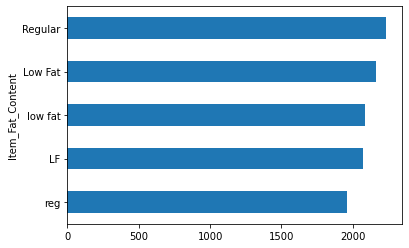

In [18]:
_ = df.groupby('Item_Fat_Content')['Item_Outlet_Sales'].mean().sort_values().plot(kind = 'barh')

In [19]:
#checking with anova and p value
# null hypothesis - less fat content items gets soled the most.
# alternative hypothesis - Less fat content item's sales dont have any relationship with it's no of sales.
def anova_fat(df):
    df_anova = df[['Item_Outlet_Sales','Item_Fat_Content']]
    grps = pd.unique(df_anova.Item_Fat_Content.values)
    d_data = {grp:df_anova['Item_Outlet_Sales'][df_anova.Item_Fat_Content == grp] for grp in grps}
    F, p = stats.f_oneway(d_data['Regular'], d_data['Low Fat'], d_data['low fat'],d_data['LF'],d_data['reg'])
    return p

In [20]:
anova_fat(df)

0.14122147854932424

As p's values is 0.14, we fail to reject the null hypothesis and therefore it is true that less fat content items gets soled the most.
Therefore while categorical encoding we can have ordinal edcoding for fat feature

I will be encoding the features according the relationship between them and target.

<h4>Categorical encoding

my deductions:-
1. for item types we can do ordinal encodings:
2. for outlet size too we can do ordinal encodings

In [21]:
encoder=OrdinalEncoder()
categ_df['Item_Type'] = encoder.fit_transform(categ_df['Item_Type'].values.reshape(-1,1))
categ_df.head()

C:\Python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Item_Type Item_Fat_Content        Outlet_Type Outlet_Location_Type  \
0        4.0          Low Fat  Supermarket Type1               Tier 1   
1       14.0          Regular  Supermarket Type2               Tier 3   
2       10.0          Low Fat  Supermarket Type1               Tier 1   
3        6.0          Regular      Grocery Store               Tier 3   
4        9.0          Low Fat  Supermarket Type1               Tier 3   

  Outlet_Identifier Outlet_Size Item_Identifier  
0            OUT049      Medium           FDA15  
1            OUT018      Medium           DRC01  
2            OUT049      Medium           FDN15  
3            OUT010         NaN           FDX07  
4            OUT013        High           NCD19

In [22]:
encoder = ce.OrdinalEncoder(cols=['Outlet_Type','Outlet_Location_Type','Item_Fat_Content'],return_df=True,mapping=[{'col':'Outlet_Type','mapping':{'Supermarket Type3':1,'Supermarket Type2':1,'Grocery Store':2,'Supermarket Type1':4}},{'col':'Outlet_Location_Type','mapping':{'Tier 1':1,'Tier 2':2,'Tier 3':3}},{'col':'Item_Fat_Content','mapping':{'Low Fat':4,'Regular':3,'LF':2,'reg':1,'low fat':1}}])
categ_df = encoder.fit_transform(categ_df)
categ_df.head()

C:\Python\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Item_Type  Item_Fat_Content  Outlet_Type  Outlet_Location_Type  \
0        4.0                 4            4                     1   
1       14.0                 3            1                     3   
2       10.0                 4            4                     1   
3        6.0                 3            2                     3   
4        9.0                 4            4                     3   

  Outlet_Identifier Outlet_Size Item_Identifier  
0            OUT049      Medium           FDA15  
1            OUT018      Medium           DRC01  
2            OUT049      Medium           FDN15  
3            OUT010         NaN           FDX07  
4            OUT013        High           NCD19

In [23]:
del categ_df['Item_Identifier']
del categ_df['Outlet_Identifier']

In [24]:
for i in range(len(categ_df['Outlet_Size'])):
    if categ_df['Outlet_Size'].iloc[i] == 'Medium':
        categ_df['Outlet_Size'].iloc[i] = 3 
    elif categ_df['Outlet_Size'].iloc[i] == 'High':
        categ_df['Outlet_Size'].iloc[i] = 2
    elif categ_df['Outlet_Size'].iloc[i] == 'Small':
        categ_df['Outlet_Size'].iloc[i] = 1

C:\Python\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
categ_df.head()

Item_Type  Item_Fat_Content  Outlet_Type  Outlet_Location_Type Outlet_Size
0        4.0                 4            4                     1           3
1       14.0                 3            1                     3           3
2       10.0                 4            4                     1           3
3        6.0                 3            2                     3         NaN
4        9.0                 4            4                     3           2

In [26]:
from missingpy import MissForest
imputer = MissForest()
categ_df_imputed = imputer.fit_transform(categ_df)

C:\Python\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



Iteration: 0
Iteration: 1
Iteration: 2


In [27]:
categ_df_imputed_d = pd.DataFrame(categ_df_imputed)
categ_df_imputed_d.columns = categ_df.columns

In [107]:
categ_df_imputed_d.head()

Item_Type  Item_Fat_Content  Outlet_Type  Outlet_Location_Type  Outlet_Size
0        4.0               4.0          4.0                   1.0          3.0
1       14.0               3.0          1.0                   3.0          3.0
2       10.0               4.0          4.0                   1.0          3.0
3        6.0               3.0          2.0                   3.0          1.0
4        9.0               4.0          4.0                   3.0          2.0

<h4> 2. Analysis of Numerical features

<h5>a. Univariate analysis of numerical features -

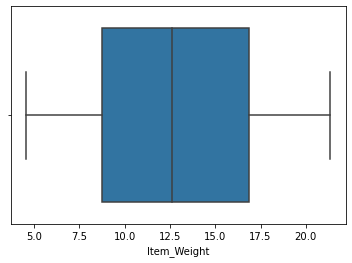

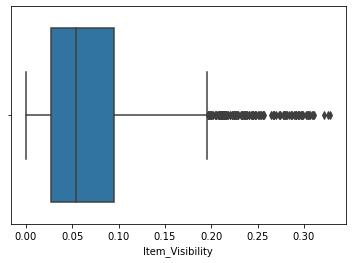

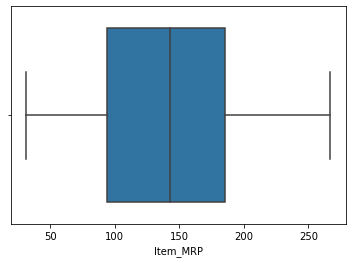

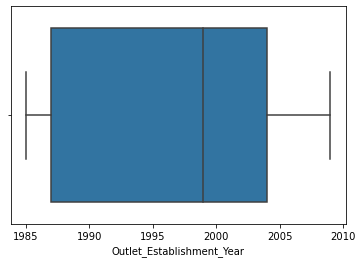

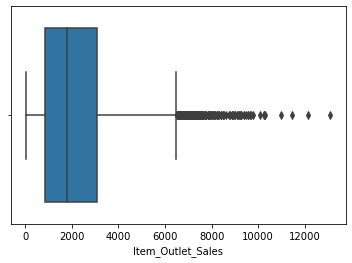

In [29]:
for i in num_df:
    sns.boxplot(x=num_df[i])
    plt.xlabel(i)
    plt.show()

observation :
1. Item visibility has many outliers
2. item outlet sales has many outliers summing upto around 4000 datapoints

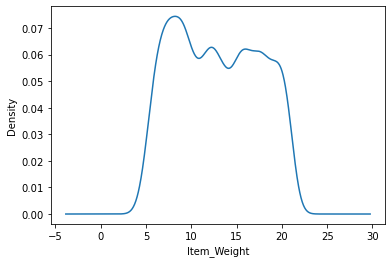

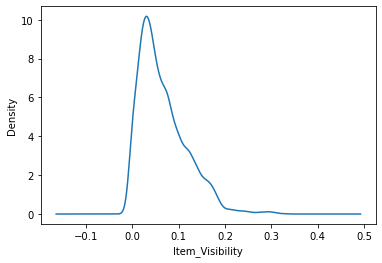

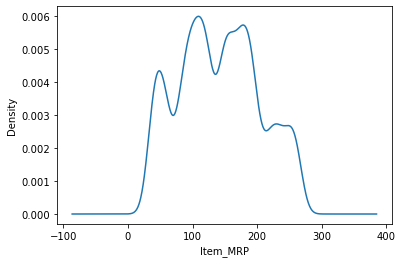

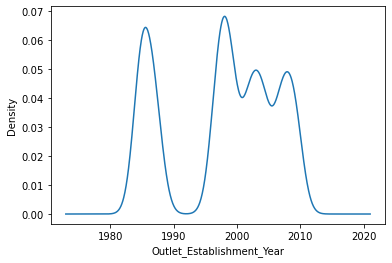

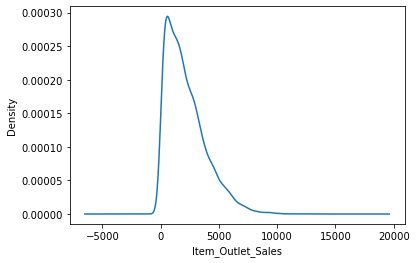

In [30]:
for i in num_df:
    num_df[i].plot.density()
    plt.xlabel(i)
    plt.show()

Outlet establingment has the most outliers. Around the year 1990 to 1994 very less amount of new restaurents opened up.

I will be removing outliers and fixing the distribution to be normal.

##### **b. Bivariate Analysis KDE plots - Relationships with Target Variable**.

In [31]:
dtale.show(num_df)

1. does light weight items get sold the most ?

In [32]:
# DISCLAIMER: 'df' refers to the data you passed in when calling 'dtale.show'

import pandas as pd

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

chart_data = pd.concat([
	df['Item_Weight'],
	df['Item_Outlet_Sales'],
], axis=1)
chart_data = chart_data.sort_values(['Item_Weight'])
chart_data = chart_data.rename(columns={'Item_Weight': 'x'})
chart_data = chart_data.groupby(['x'])[['Item_Outlet_Sales']].sum().reset_index()
chart_data = chart_data.dropna()

import plotly.graph_objs as go

chart = go.Scattergl(
	x=chart_data['x'], y=chart_data['Item_Outlet_Sales'],  mode='markers', opacity=0.7, name='all',
	marker={'size': 15, 'line': {'width': 0.5, 'color': 'white'}}
)

figure = go.Figure(data=[chart], layout=go.Layout({
    'legend': {'orientation': 'h'},
    'title': {'text': 'Item_Outlet_Sales by Item_Weight (Sum)'},
    'xaxis': {'title': {'text': 'Item_Weight'}},
    'yaxis': {'title': {'text': 'Item_Outlet_Sales (Sum)'}}
}))


# If you're having trouble viewing your chart in your notebook try passing your 'chart' into this snippet:

# from plotly.offline import iplot, init_notebook_mode

# init_notebook_mode(connected=True)
# chart.pop('id', None) # for some reason iplot does not like 'id'
# iplot(chart)

In [33]:
figure

conclusion - 
1. It seems clearly true that light weight items are sold the most.

2. do more visibility products get sold the most ?

In [34]:
# DISCLAIMER: 'df' refers to the data you passed in when calling 'dtale.show'

import pandas as pd

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

chart_data = pd.concat([
	df['Item_Visibility'],
	df['Item_Outlet_Sales'],
], axis=1)
chart_data = chart_data.sort_values(['Item_Visibility'])
chart_data = chart_data.rename(columns={'Item_Visibility': 'x'})
chart_data = chart_data.dropna()

import plotly.graph_objs as go

chart = go.Scattergl(
	x=chart_data['x'], y=chart_data['Item_Outlet_Sales'], mode='markers', opacity=0.7, name='all',
	marker={'size': 15, 'line': {'width': 0.5, 'color': 'white'}}
)

figure = go.Figure(data=[chart], layout=go.Layout({
    'legend': {'orientation': 'h'},
    'title': {'text': 'Item_Outlet_Sales by Item_Visibility (No Aggregation)'},
    'xaxis': {'title': {'text': 'Item_Visibility'}},
    'yaxis': {'title': {'text': 'Item_Outlet_Sales (No Aggregation)'}}
}))

# If you're having trouble viewing your chart in your notebook try passing your 'chart' into this snippet:

# from plotly.offline import iplot, init_notebook_mode

# init_notebook_mode(connected=True)
# chart.pop('id', None) # for some reason iplot does not like 'id'
# iplot(chart)

In [35]:
figure

conclusion- 
No, it's not true that the products which has more % of total display area of all products in a store allocated gets sold more.

3. do cheap products get sold the most ?

In [36]:
# DISCLAIMER: 'df' refers to the data you passed in when calling 'dtale.show'

import pandas as pd

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

chart_data = pd.concat([
	df['Item_MRP'],
	df['Item_Outlet_Sales'],
], axis=1)
chart_data = chart_data.sort_values(['Item_MRP'])
chart_data = chart_data.rename(columns={'Item_MRP': 'x'})
chart_data = chart_data.dropna()

import plotly.graph_objs as go

chart = go.Scattergl(
	x=chart_data['x'], y=chart_data['Item_Outlet_Sales'], mode='markers', opacity=0.7, name='all',
	marker={'size': 15, 'line': {'width': 0.5, 'color': 'white'}}
)

figure = go.Figure(data=[chart], layout=go.Layout({
    'legend': {'orientation': 'h'},
    'title': {'text': 'Item_Outlet_Sales by Item_MRP (No Aggregation)'},
    'xaxis': {'title': {'text': 'Item_MRP'}},
    'yaxis': {'title': {'text': 'Item_Outlet_Sales (No Aggregation)'}}
}))

# If you're having trouble viewing your chart in your notebook try passing your 'chart' into this snippet:

# from plotly.offline import iplot, init_notebook_mode

# init_notebook_mode(connected=True)
# chart.pop('id', None) # for some reason iplot does not like 'id'
# iplot(chart)

In [37]:
figure

conclusion-
No, it can clearly been seen that more mrp item gets sold more than cheaper mrp items. Which goes to show that 

4. do older established marts have more selling rate of a product than newly established ?

In [38]:
# DISCLAIMER: 'df' refers to the data you passed in when calling 'dtale.show'

import pandas as pd

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

chart_data = pd.concat([
	df['Outlet_Establishment_Year'],
	df['Item_Outlet_Sales'],
], axis=1)
chart_data = chart_data.sort_values(['Outlet_Establishment_Year'])
chart_data = chart_data.rename(columns={'Outlet_Establishment_Year': 'x'})
chart_data = chart_data.dropna()

import plotly.graph_objs as go

chart = go.Scattergl(
	x=chart_data['x'], y=chart_data['Item_Outlet_Sales'], mode='markers', opacity=0.7, name='all',
	marker={'size': 15, 'line': {'width': 0.5, 'color': 'white'}}
)

figure = go.Figure(data=[chart], layout=go.Layout({
    'legend': {'orientation': 'h'},
    'title': {'text': 'Item_Outlet_Sales by Outlet_Establishment_Year (No Aggregation)'},
    'xaxis': {'tickformat': '.0f', 'title': {'text': 'Outlet_Establishment_Year'}},
    'yaxis': {'title': {'text': 'Item_Outlet_Sales (No Aggregation)'}}
}))

# If you're having trouble viewing your chart in your notebook try passing your 'chart' into this snippet:

# from plotly.offline import iplot, init_notebook_mode

# init_notebook_mode(connected=True)
# chart.pop('id', None) # for some reason iplot does not like 'id'
# iplot(chart)

In [39]:
figure

yes, it seems true for the year 1985, but then in later years the number of establishments remain almost constant.

now I have to remove outliers, make distribution normal and make relationships linear w.r.t target variable.

Building a baseline model to set a benchmark for accuracy accuracynd score.

In [40]:
#removing missing values in item weight.
num_df = pd.DataFrame(num_df.fillna(num_df.median()))

In [41]:
#removing outliers in item_visibility feature
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

In [42]:
lowerbound,upperbound = outlier_treatment(num_df['Item_Visibility'])
for j in range(len(num_df['Item_Visibility'])):
    if ((num_df['Item_Visibility'].iloc[j] > upperbound)  | (num_df['Item_Visibility'].iloc[j] < lowerbound)):
        a = num_df['Item_Visibility'].median()
        num_df['Item_Visibility'] = num_df['Item_Visibility'].replace(num_df['Item_Visibility'].iloc[j],a)

C:\Python\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



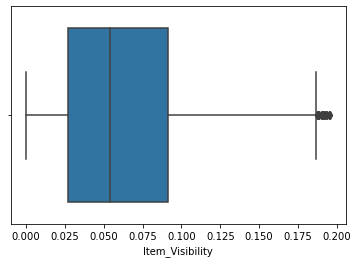

In [43]:
sns.boxplot(num_df['Item_Visibility'])
plt.xlabel('Item_Visibility')
plt.show()

If we compare boxplot before and after removal of outliers for item_visibility feature, we can see that very few outliers are left, also their value has decreased to 0.2 form 0.3 which seems pretty comfortable to work with.

In [44]:
num_df.describe()

Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count   8523.00000      8523.000000  8523.000000                8523.000000   
mean      12.81342         0.062907   140.992782                1997.831867   
std        4.22724         0.045753    62.275067                   8.371760   
min        4.55500         0.000000    31.290000                1985.000000   
25%        9.31000         0.026989    93.826500                1987.000000   
50%       12.60000         0.053931   143.012800                1999.000000   
75%       16.00000         0.091097   185.643700                2004.000000   
max       21.35000         0.195721   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800

<AxesSubplot:>

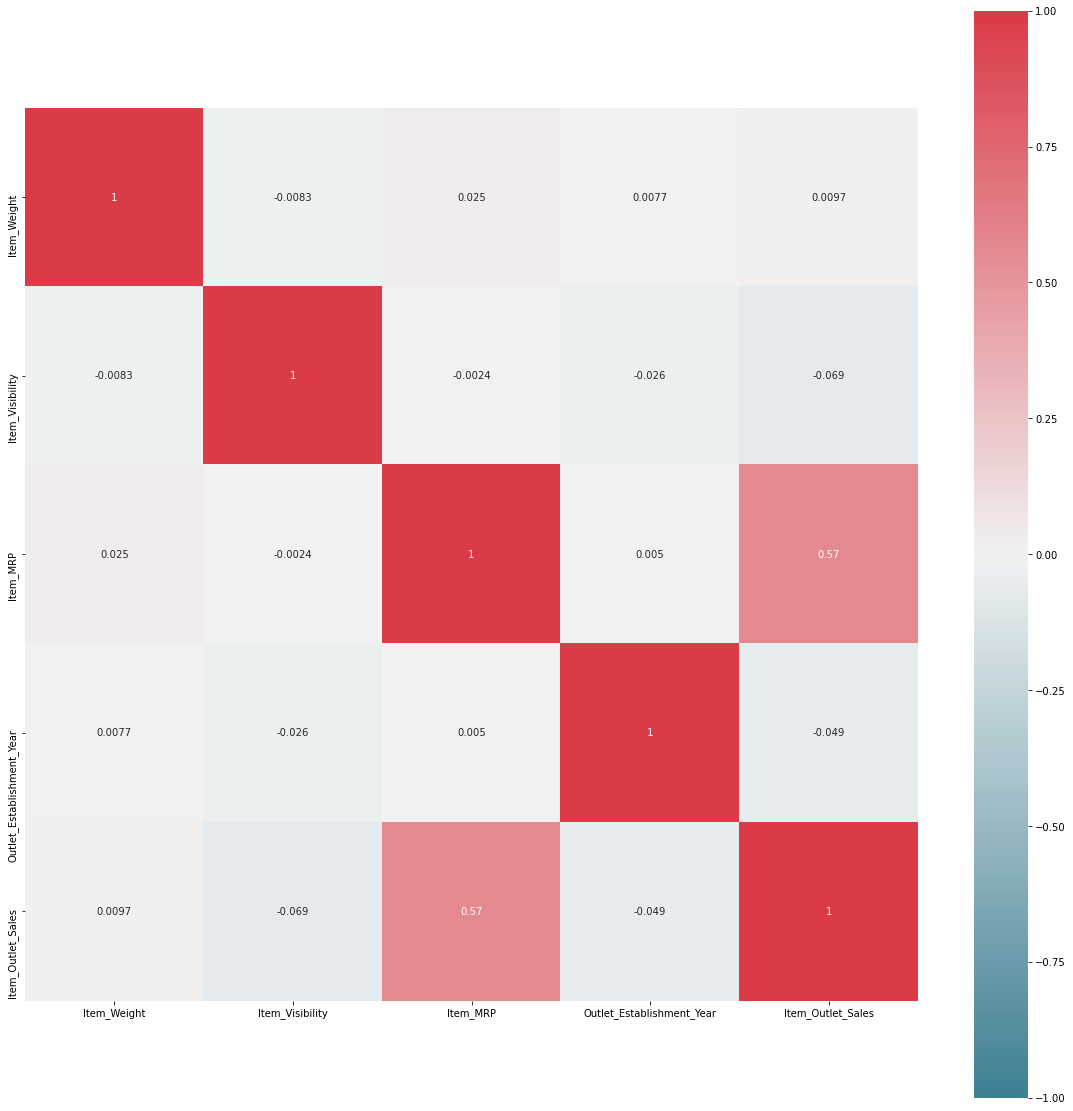

In [45]:
f, ax = plt.subplots(figsize=(20, 20))
corr = num_df.corr()
sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center= 0, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Conclusions - 
1. there is no case of multi collinearity.
2. only feature mrp is highly correlated with outr target feature item outlet sales.
3. Item_weight feature has very low correlation with outlet sales, but we cant delete it, as we have seen from weight scatter plot that lower weighted items have sold more than higher priced ones.
3. for other features we will try feature engineering to improve correlation with target feature.

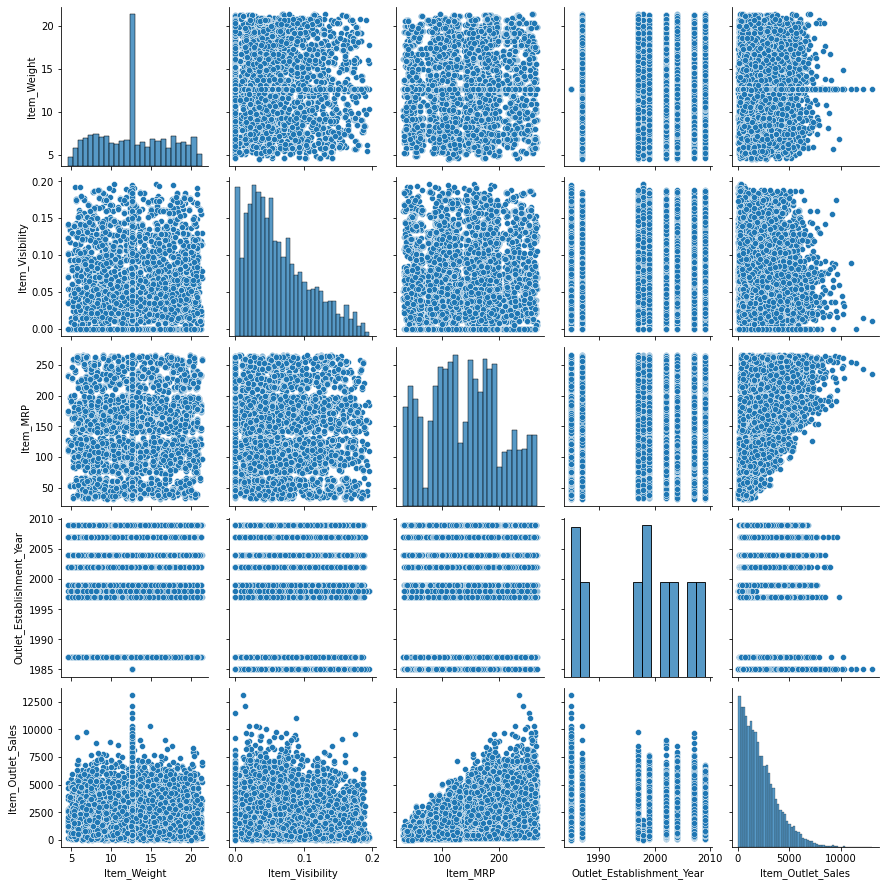

In [46]:
sns.pairplot(num_df)

observation -
1. As we can see the relationship of features with target is far from linear, so not even going to try to make it linear.

Now trying to make distribution normal of individual features

In [47]:
num_df_log = num_df.copy()
num_df_log['Item_Weight'] = np.sqrt(num_df['Item_Weight'])

<AxesSubplot:xlabel='Item_Weight', ylabel='Density'>

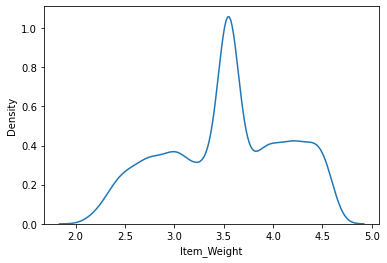

In [48]:
sns.kdeplot(num_df_log['Item_Weight'])

<AxesSubplot:xlabel='Item_Visibility', ylabel='Density'>

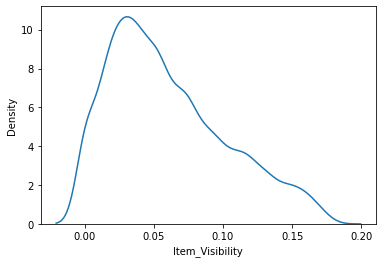

In [49]:
import math
num_df_log['Item_Visibility'] = np.log1p((num_df['Item_Visibility']))
sns.kdeplot(num_df_log['Item_Visibility'])

<AxesSubplot:xlabel='Item_Outlet_Sales', ylabel='Density'>

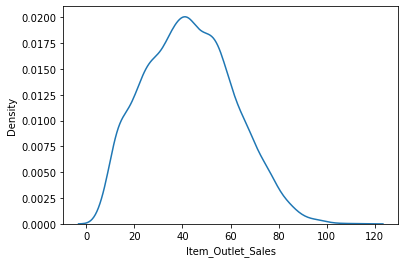

In [50]:
num_df_log['Item_Outlet_Sales'] = np.sqrt((num_df['Item_Outlet_Sales']))
sns.kdeplot(num_df_log['Item_Outlet_Sales'])

It wasent possible to make every distribution normal, but finally was able to make gaussian like.

<AxesSubplot:>

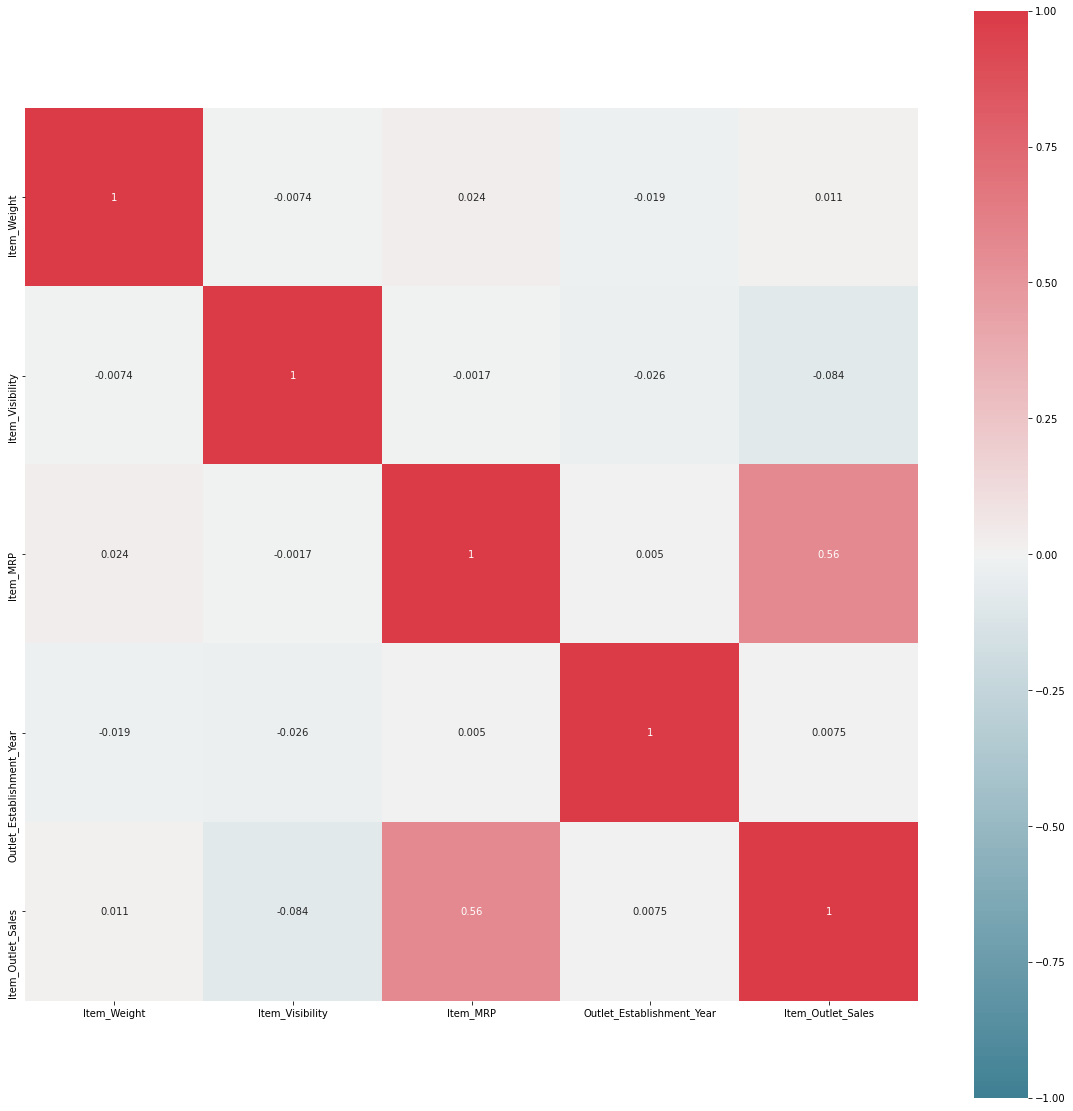

In [51]:
f, ax = plt.subplots(figsize=(20, 20))
corr = num_df_log.corr()
sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center= 0, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

conclusion :-
1. As we can see correlation with target feature has improved a bit as feature engineering, but still not satisfactory to select best feature from it.

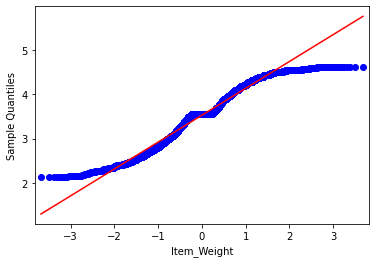

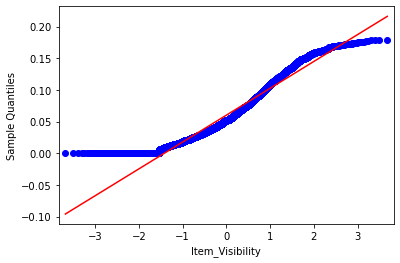

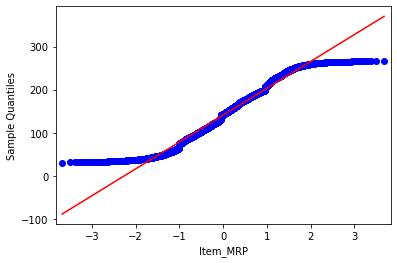

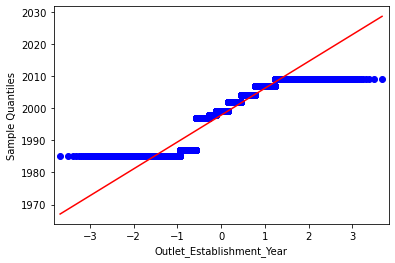

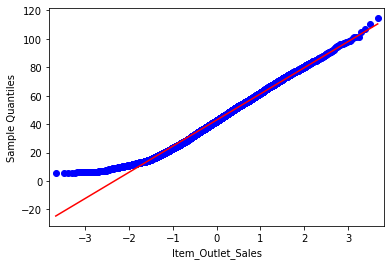

In [52]:
import pylab
import statsmodels.api as sm
for i in num_df_log:
    sm.qqplot(num_df_log[i], line='s')
    plt.xlabel(i)
    pylab.show()

Conclusion:-
1. As our data is not gaussian even after log transformations, we will skip simple linear regression models.

In [77]:
final_1 = pd.concat([categ_df_imputed_d, num_df_log], axis = 1)

In [78]:
y_1 = final_1['Item_Outlet_Sales']
X_1 = final_1.drop('Item_Outlet_Sales',axis = 1)

<h5> Applying Feature selection techniques

In [87]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestRegressor
model=sfs(RandomForestRegressor(),k_features=6,forward=True,verbose=2,cv=5,n_jobs=-1,scoring='r2')
model.fit(X_1,y_1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    1.4s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    6.3s finished

[2020-10-06 22:22:10] Features: 1/6 -- score: 0.2953772347570603[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    1.6s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.2s finished

[2020-10-06 22:22:16] Features: 2/6 -- score: 0.4601325434100779[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    8.9s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:   10.5s finished

[2020-10-06 22:22:27] F

SequentialFeatureSelector(estimator=RandomForestRegressor(), k_features=6,
                          n_jobs=-1, scoring='r2', verbose=2)

In [88]:
X_1.columns

Index(['Item_Type', 'Item_Fat_Content', 'Outlet_Type', 'Outlet_Location_Type',
       'Outlet_Size', 'Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')

In [89]:
model.k_feature_names_

('Outlet_Type',
 'Outlet_Size',
 'Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year')

In [90]:
model.k_feature_idx_

(2, 4, 5, 6, 7, 8)

In [91]:
new_df  = pd.DataFrame([])
new_df = final_1[['Outlet_Type','Outlet_Size','Item_Weight','Item_Visibility','Item_MRP','Outlet_Establishment_Year']]
b4_std = pd.concat([new_df, y_1], axis = 1)

In [55]:
colnames = X_1.columns

In [56]:
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [57]:
ranks = {}
rfr = RandomForestRegressor()
rfr.fit(X_1,y_1)
#stop the search when only the last feature is left
rfe = RFE(rfr, n_features_to_select=1, verbose =3 )
rfe.fit(X_1,y_1)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


In [58]:
ranks["RFE"]

{'Item_Type': 0.25,
 'Item_Fat_Content': 0.12,
 'Outlet_Type': 0.88,
 'Outlet_Location_Type': 0.0,
 'Outlet_Size': 0.38,
 'Item_Weight': 0.5,
 'Item_Visibility': 0.75,
 'Item_MRP': 1.0,
 'Outlet_Establishment_Year': 0.62}

In [92]:
final_std = new_df.copy()
from sklearn.preprocessing import StandardScaler
my_created_transformer = StandardScaler()
for i in b4_std:
    my_created_transformer.fit(b4_std[i].values.reshape(-1, 1))
    final_std[i] = my_created_transformer.transform(b4_std[i].values.reshape(-1, 1))

In [93]:
y = final_std['Item_Outlet_Sales']
X = final_std.drop('Item_Outlet_Sales',axis = 1)

<h5> Preparing test data.

In [94]:
df_t = pd.read_csv(r'C:\Users\admin\Downloads\test_AbJTz2l.csv')
df_t.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility    Item_Type  \
0           FDW58       20.750          Low Fat         0.007565  Snack Foods   
1           FDW14        8.300              reg         0.038428        Dairy   
2           NCN55       14.600          Low Fat         0.099575       Others   
3           FDQ58        7.315          Low Fat         0.015388  Snack Foods   
4           FDY38          NaN          Regular         0.118599        Dairy   

   Item_MRP Outlet_Identifier  Outlet_Establishment_Year Outlet_Size  \
0  107.8622            OUT049                       1999      Medium   
1   87.3198            OUT017                       2007         NaN   
2  241.7538            OUT010                       1998         NaN   
3  155.0340            OUT017                       2007         NaN   
4  234.2300            OUT027                       1985      Medium   

  Outlet_Location_Type        Outlet_Type  
0               Tier 1  Supermarket Type1  
1               Tier 2  Supermarket Type1  
2               Tier 3      Grocery Store  
3               Tier 2  Supermarket Type1  
4               Tier 3  Supermarket Type3

In [95]:
submission =pd.DataFrame([])
submission['Item_Identifier'] = df_t['Item_Identifier']
submission['Outlet_Identifier'] = df_t['Outlet_Identifier']

In [96]:
del df_t['Item_Identifier']
del df_t['Outlet_Identifier']
del df_t['Item_Type']
del df_t['Outlet_Location_Type']
del df_t['Item_Fat_Content']

In [97]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                4705 non-null   float64
 1   Item_Visibility            5681 non-null   float64
 2   Item_MRP                   5681 non-null   float64
 3   Outlet_Establishment_Year  5681 non-null   int64  
 4   Outlet_Size                4075 non-null   object 
 5   Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 266.4+ KB


In [98]:
df_t['Item_Weight'] = df_t['Item_Weight'].fillna(df_t['Item_Weight'].median())

In [99]:
encoder = ce.OrdinalEncoder(cols=['Outlet_Type'],return_df=True,mapping=[{'col':'Outlet_Type','mapping':{'Supermarket Type3':1,'Supermarket Type2':1,'Grocery Store':2,'Supermarket Type1':4}}])
df_t = encoder.fit_transform(df_t)
df_t.head()

C:\Python\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
0       20.750         0.007565  107.8622                       1999   
1        8.300         0.038428   87.3198                       2007   
2       14.600         0.099575  241.7538                       1998   
3        7.315         0.015388  155.0340                       2007   
4       12.500         0.118599  234.2300                       1985   

  Outlet_Size  Outlet_Type  
0      Medium            4  
1         NaN            4  
2         NaN            2  
3         NaN            4  
4      Medium            1

In [100]:
for i in range(len(df_t['Outlet_Size'])):
    if df_t['Outlet_Size'].iloc[i] == 'Medium':
        df_t['Outlet_Size'].iloc[i] = 3 
    elif df_t['Outlet_Size'].iloc[i] == 'High':
        df_t['Outlet_Size'].iloc[i] = 2
    elif df_t['Outlet_Size'].iloc[i] == 'Small':
        df_t['Outlet_Size'].iloc[i] = 1

C:\Python\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [101]:
from missingpy import MissForest
imputer = MissForest()
df_t_imputed = imputer.fit_transform(df_t)

Iteration: 0
Iteration: 1
Iteration: 2


In [102]:
df_imputed_d = pd.DataFrame(df_t_imputed)
df_imputed_d.columns = df_t.columns

In [104]:
df_imputed_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                5681 non-null   float64
 1   Item_Visibility            5681 non-null   float64
 2   Item_MRP                   5681 non-null   float64
 3   Outlet_Establishment_Year  5681 non-null   float64
 4   Outlet_Size                5681 non-null   float64
 5   Outlet_Type                5681 non-null   float64
dtypes: float64(6)
memory usage: 266.4 KB


In [108]:
df_t_std = df_imputed_d.copy()
from sklearn.preprocessing import StandardScaler
my_created_transformer = StandardScaler()
for i in df_t_std:
    my_created_transformer.fit(df_imputed_d[i].values.reshape(-1, 1))
    df_t_std[i] = my_created_transformer.transform(df_imputed_d[i].values.reshape(-1, 1))

<h5> Using random forest regressor as model

In [110]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
forest =RandomForestRegressor()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 45, num = 3)]
# Minimum number of samples required to split a node
min_samples_split = [5, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}
pprint(random_grid)

{'max_depth': [1, 23, 45],
 'max_features': ['auto', 'sqrt'],
 'min_samples_split': [5, 10],
 'n_estimators': [20, 65, 110, 155, 200]}


In [111]:
rf_random = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 10, cv = 10, verbose=2, random_state=42, n_jobs = -1, scoring='neg_mean_squared_error')
# Fit the random search model
rf_random.fit(X, y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.9s finished


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [1, 23, 45],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [20, 65, 110, 155,
                                                         200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [112]:
rf_random.best_params_

{'n_estimators': 110,
 'min_samples_split': 10,
 'max_features': 'sqrt',
 'max_depth': 45}

In [113]:
Item_outlet_sales = []

In [114]:
rfr_t = RandomForestRegressor(n_estimators=110, criterion='mse', max_depth=45, min_samples_split=10, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)
rfr_t.fit(X, y)
Item_outlet_sales = rfr_t.predict(df_t_std)

In [115]:
submission['Item_Outlet_Sales'] = abs(Item_outlet_sales)

In [116]:
submission.to_csv('randomforest.csv')

In [76]:
submission.head()

Item_Identifier Outlet_Identifier  Item_Outlet_Sales
0           FDW58            OUT049           0.370526
1           FDW14            OUT017           0.190932
2           NCN55            OUT010           0.385244
3           FDQ58            OUT017           0.495156
4           FDY38            OUT027           1.156452

<h5> Applying xgbregressor

In [117]:
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = RandomizedSearchCV(estimator = xgb_model,
                           param_distributions = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [118]:
hyperParameterTuning(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.7s finished


{'subsample': 0.7,
 'objective': 'reg:squarederror',
 'n_estimators': 500,
 'min_child_weight': 5,
 'max_depth': 5,
 'learning_rate': 0.01,
 'colsample_bytree': 0.7}

In [120]:
df_t_std = pd.DataFrame(df_t_std,columns=['Outlet_Type','Outlet_Size','Item_Weight','Item_Visibility','Item_MRP','Outlet_Establishment_Year'])

In [121]:
xgb_model = XGBRegressor(objective = 'reg:squarederror',colsample_bytree = 0.7,learning_rate = 0.001,
        max_depth = 5,
        min_child_weight = 5,
        n_estimators = 500,
        subsample = 0.7)

xgb_model.fit(X, y)

y_pred_xgb = xgb_model.predict(df_t_std)

In [123]:
del submission['Item_Outlet_Sales']

In [124]:
submission['Item_Outlet_Sales'] = abs(y_pred_xgb)

In [125]:
submission.to_csv('Bigmart_xgb.csv')